# Introduction

The following notebook demonstates one of the strategies that I developed in order to trade cryptocurrencies. This a moving averages crossover strategy. My thought was that many traders trade based on these patterns since there is not much else to evaluate these new assets.  I also wanted to take a look at volume times based on the day of the week so that I could position myself to take advantage of increased volume.



# Data Retrieval

I obtained this data through the Binance client found [here](https://github.com/sammchardy/python-binance). The cDW (crypto data window) function below returns end of day data points such as time, close, volume, high, and low.  This function also made some calculations such as finding the 5 and 10 day rolling averages for the close and volume columns.  It also calculates sma crossover percentages and the percent change from previous day. 

In [3]:
from binance.client import Client
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

api_key = 'Enter your key here'
api_secret = "Enter your secret here"
client = Client(api_key, api_secret)

def cDW(crypto, window):
    data = client.get_historical_klines("%s" % crypto, Client.KLINE_INTERVAL_1DAY, "%s days ago UTC" % str(window))
    df = pd.DataFrame(data)
    df.columns = ['OTime', 'Open', 'High', 'Low', 'Close', 'Volume', 'CTime', 'Quote Asset Volume', '# of Trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'ignored']
    df['OTime'] = pd.to_datetime(df['OTime'].astype(int), unit='ms')
    df['CTime'] = pd.to_datetime(df['CTime'].astype(int), unit='ms')
    df['Close'] = df['Close'].astype(float)
    df['Volume'] = df['Volume'].astype(float)
    df['High'] = df['High'].astype(float)
    df['Low'] = df['Low'].astype(float)
    df['sma5'] = df['Close'].rolling(5).mean()
    df['sma10'] = df['Close'].rolling(10).mean()
    df['Volsma5'] = df['Volume'].rolling(5).mean()
    df['Volsma10'] = df['Volume'].rolling(10).mean()
    df['sma30'] = df['Close'].rolling(30).mean()
    df['VolsmaPCT'] = df['Volsma5']/df['Volsma10']
    df['smaPCT'] = df['sma5']/df['sma10']
    df['score'] = df['smaPCT'] + .2*df['VolsmaPCT']
    df['backtest'] = df['Close'].shift(-2)/df['Close'].shift(-1) - 1
    df['CryptoName'] = crypto
    df = df.set_index(['OTime', 'CryptoName'])
    return df



This next code loops through each ticker available from Binance and runs it through the cDW function.  The results are appended to a list and the ending list is concatenated into a pandas dataframe.

In [18]:
ts = client.get_all_tickers()
ts = pd.DataFrame(ts)
ts = ts.loc[ts['symbol'].str.contains('BTC')]
ts = ts['symbol']

cData = []
for c in ts:
    cData.append(cDW(c, 180))
df = pd.concat(cData)
df.head()

,,Open,High,Low,Close,Volume,CTime,Quote Asset Volume,# of Trades,Taker buy base asset volume,Taker buy quote asset volume,ignored,sma5,sma10,Volsma5,Volsma10,sma30,VolsmaPCT,smaPCT,score,backtest
OTime,CryptoName,,,,,,,,,,,,,,,,,,,,
2017-09-27,ETHBTC,0.07449200,0.074731,0.071977,0.073445,44263.081,2017-09-27 23:59:59.999,3244.84779012,33430,23669.17200000,1735.73878839,74084.88778690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.022052
2017-09-28,ETHBTC,0.07346500,0.073700,0.071509,0.072509,52476.402,2017-09-28 23:59:59.999,3807.32971704,46234,28181.11300000,2045.52277031,82349.71463412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011959
2017-09-29,ETHBTC,0.07250700,0.072590,0.069015,0.070910,40578.601,2017-09-29 23:59:59.999,2864.26565857,40812,20067.43000000,1417.59131521,81911.33521906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.013659
2017-09-30,ETHBTC,0.07087800,0.073300,0.069401,0.070062,37140.806,2017-09-30 23:59:59.999,2622.79601338,41460,17491.19700000,1236.54940711,88439.42297005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.006468
2017-10-01,ETHBTC,0.07018100,0.071484,0.068109,0.069105,38693.377,2017-10-01 23:59:59.999,2694.17980938,41213,18853.07200000,1313.43391925,96631.95210275,0.071206,NaN,42630.4534,NaN,NaN,NaN,NaN,NaN,-0.009351


Now that we have the data from every crypto from the last 180 days we can start to explore

# Day of Week

I wanted to see how the volume varied by the day of week so I grouped all of the returns (col='backtest') by day of week and returned the average of each. The day of the week that stands out is the returns from Fridays located at dow=3. 

This gave me the idea to invest in the riskier alt coins on Thursday to ride Fridays gains, then switch to less volatile cryptos on Sunday to avoid Mondays drops.

In [19]:
df['dow'] = df.index.get_level_values('OTime').dayofweek
byDow = df.groupby('dow')
byDow['backtest'].mean()

dow
0    0.000782
1    0.002247
2    0.011907
3    0.022114
4    0.001304
5    0.012334
6   -0.004629
Name: backtest, dtype: float64

,count,mean,std,min,25%,50%,75%,max
dow,,,,,,,,
0,2049.0,0.000782,0.128234,-0.331935,-0.059432,-0.014932,0.035398,1.159091
1,2068.0,0.002247,0.121372,-0.395481,-0.049210,-0.007123,0.037570,1.147385
2,2100.0,0.011907,0.147878,-0.395066,-0.043698,-0.001769,0.044853,4.133750
3,2120.0,0.022114,0.150371,-0.397105,-0.043853,-0.003916,0.051793,3.716022
4,2144.0,0.001304,0.101444,-0.505489,-0.053220,-0.016864,0.027193,0.774804
5,2028.0,0.012334,0.116167,-0.325000,-0.047028,-0.011280,0.051039,0.975542
6,2029.0,-0.004629,0.105955,-0.295370,-0.063476,-0.016411,0.040339,0.626934


# Backtest

Finally it's time for the backtest of the strategy.  

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

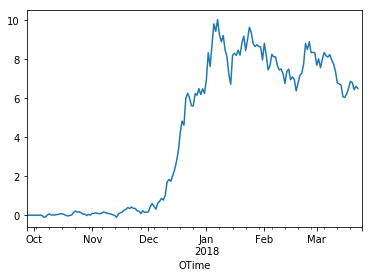

In [44]:
# Create column to pull out by crypto name easier
df['CryptoName'] = df.index.get_level_values('CryptoName')
# rank by their sma crossover score
df['rank'] = df['score'].groupby('OTime').rank(ascending=False)
# I chose btc as the less volatile crypto to hold on days Monday thru Thursday
btc = df.loc[(df['CryptoName'] == 'BTCUSDT') & (df['dow'].isin([0,1,2,3]))]
# The rest are all the alt coins on days Friday, Saturday, Sunday
alt = df.loc[(df['CryptoName'] != 'BTCUSDT') & (df['dow'].isin([4,5,6]))]
# On btc days the long will always be holding btc and it will be 100 percent of our portfolio
btc['longs'] = 1
btc['percentPortfolio'] = 1
# On alt days we choose the top 5 ranked sma crossover cryptos and give each of them a 20% position in the portfolio
alt['longs'] = np.where(alt['rank'] < 6, 1, 0)
alt['percentPortfolio'] = .2
# Combine the btc and alt dataframes in order to calculate what the strategy would produce for each day
combined = pd.concat([btc, alt])
combined['strategy'] = combined['backtest'] * combined['longs'] * combined['percentPortfolio']
# Get the daily totals by grouping by day and taking the sum of all returns from the strategy in that day
dailyTotals = combined.groupby('OTime')['strategy'].sum()
# Next get the cumulative product to give you actual return in the end
dailyTotals['cumprod'] = (1 + totals['strategy']).cumprod() - 1
# Then plot the results
totals['cumprod'].plot()
plt.show()



# We're going to be rich!

Well, not really.  Even though this strategy claims to give us a 10x return on our money there are some issues I have found with this strategy.  I will explain below.

# Problems

#### 1. There maybe little statistical significance to the average returns by day of week.

    Looking at results from the describe function we can see that the standard deviation is too high.  The error bar chart shows how much the average return varies just one standard deviation from the mean.

In [45]:
byDow['backtest'].describe()

,count,mean,std,min,25%,50%,75%,max
dow,,,,,,,,
0,2049.0,0.000782,0.128234,-0.331935,-0.059432,-0.014932,0.035398,1.159091
1,2068.0,0.002247,0.121372,-0.395481,-0.049210,-0.007123,0.037570,1.147385
2,2100.0,0.011907,0.147878,-0.395066,-0.043698,-0.001769,0.044853,4.133750
3,2120.0,0.022114,0.150371,-0.397105,-0.043853,-0.003916,0.051793,3.716022
4,2144.0,0.001304,0.101444,-0.505489,-0.053220,-0.016864,0.027193,0.774804
5,2028.0,0.012334,0.116167,-0.325000,-0.047028,-0.011280,0.051039,0.975542
6,2029.0,-0.004629,0.105955,-0.295370,-0.063476,-0.016411,0.040339,0.626934


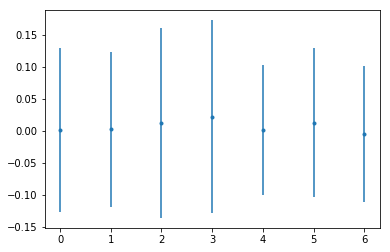

In [46]:
mean = byDow['backtest'].mean()
std = byDow['backtest'].std()

plt.errorbar(np.array(mean.index), np.array(mean), np.array(std), linestyle='None', marker='.')
plt.plot()
plt.show()

#### 2.  Timeframe

    This timeframe was taken in the last 180 days, October 2017 to March 2018. This was right about the time cryptocurrencies were showing their fastest growth ever.  There is no way I should expect to see this type of growth in the future.  My suggestion is to gather data from less volatile time periods and examine those patterns.